## Reset env - import/install package

In [1]:
# clear all elements from environment
rm(list=ls())      #will clear all objects includes hidden objects.
gc(reset = TRUE)   #free up memrory and report the memory usage.

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,595918,31.9,1271675,68,595918,31.9
Vcells,1066917,8.2,8388608,64,1066917,8.2


In [2]:
# sources from which this notebook was build:
#   R Packages Vignettes: 
#     https://cran.r-project.org/web/packages/MatchIt/vignettes/MatchIt.html
#     https://bioconductor.org/help/course-materials/2015/BioC2015/
#     https://bioconductor.org/packages/release/bioc/html/minfi.html
#     https://bioconductor.org/packages/release/workflows/html/methylationArrayAnalysis.html
#   Others:
#     https://vbaliga.github.io/verify-that-r-packages-are-installed-and-loaded/


packages = c("BiocManager", "MatchIt", "limma", "minfi", "ggplot2", "ggrepel", "RColorBrewer", "devtools", "Rtsne", "gridExtra") #, "RSpectra", "purrr", "missMethyl")

package.check <- lapply(
    packages,
    FUN = function(x) {
        if (!require(x, character.only = TRUE)) {
            install.packages(x, dependencies = TRUE)
            library(x, character.only = TRUE)
        }
    }
)


devtools::install_github("yanlinlin82/ggvenn")

# install.packages("ggalt", repos=c("http://rstudio.org/_packages","http://cran.rstudio.com",dependencies=TRUE))
# install.packages("ggrastr", repos=c("http://rstudio.org/_packages","http://cran.rstudio.com",dependencies=TRUE))

Loading required package: BiocManager

Warning message:
"package 'BiocManager' was built under R version 4.2.0"
Bioconductor version '3.14' is out-of-date; the current release version '3.15'
  is available with R version '4.2'; see https://bioconductor.org/install

Loading required package: MatchIt

Loading required package: limma

Loading required package: minfi

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following object is masked from 'package:limma':

    plotMA


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    

## Figures buffer (for PDF file)

In [3]:
# to save figures
fig_buffer = list()
fig_id = 1

set.seed(42) # for reprod.

## Load Preprocessed Data

### GSE97362 : CHARGE and Kabuki

In [4]:
load(file.path(  'CLEAN_GSE97362_GMset_metadata.RData' ))

meta.GSE97362 <- metadata
GMset.GSE97362  <- GMset_norma


table(meta.GSE97362$disease_id)
head(meta.GSE97362)
GMset.GSE97362 


 CHD7  CTRL KDM6A KMT2D 
   72   124     1    37 

,geo_accession,disease_state,gender,disease_id,age_cat,age,geo,CD8T,CD4T,NK,Bcell,Mono,Gran
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GSM2562699,GSM2562699,CHARGE,F,CHD7,child,4,GSE97362,0.06967934,0.09427878,0.04507859,0.08818601,0.08709501,0.6346177
GSM2562700,GSM2562700,CHARGE,M,CHD7,child,6,GSE97362,0.11469408,0.26745953,0.00000000,0.17782392,0.07731675,0.3679182
GSM2562701,GSM2562701,CHARGE,F,CHD7,child,14,GSE97362,0.07508270,0.08847265,0.03812342,0.09289824,0.08190727,0.6528255
GSM2562702,GSM2562702,CHARGE,M,CHD7,child,13,GSE97362,0.05377055,0.09871871,0.08005810,0.07699523,0.10400492,0.5846645
GSM2562703,GSM2562703,CHARGE,M,CHD7,youth,18,GSE97362,0.02973212,0.07313688,0.07660993,0.03321590,0.15637060,0.6454320
GSM2562704,GSM2562704,CHARGE,M,CHD7,youth,24,GSE97362,0.03360435,0.09951186,0.03491155,0.06145267,0.10661247,0.6766679


class: GenomicMethylSet 
dim: 429649 234 
metadata(0):
assays(2): Meth Unmeth
rownames(429649): cg13869341 cg24669183 ... cg19565306 cg09226288
rowData names(0):
colnames(234): GSM2562699 GSM2562700 ... GSM2562934 GSM2562935
colData names(3): xMed yMed predictedSex
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19
Preprocessing
  Method: NA
  minfi version: NA
  Manifest version: NA

##### Samples Matching (Cas VS Control Groups)

- CHARGE

In [5]:
library("MatchIt")

cat('CHARGE: Samples Matching')

cohort.CHARGE <- meta.GSE97362[meta.GSE97362$disease_id == "CHD7"  | meta.GSE97362$disease_id == "CTRL", ]
table(cohort.CHARGE$disease_id)

design.CHARGE <- model.matrix(~0 + disease_id + age + gender, data = data.frame(cohort.CHARGE))

match.CHARGE  <- matchit(disease_idCHD7 ~  age + genderM, data = data.frame(design.CHARGE)) 
match.CHARGE

groups.CHARGE <- data.frame(match.CHARGE$match.matrix[!is.na(match.CHARGE$match.matrix), ]) # case (row names) and control groups (val in col)
case.CHARGE <- rownames(groups.CHARGE)
ctrl.CHARGE <- groups.CHARGE[,1]

meta.GSE97362[case.CHARGE[1],]$disease_id
##############################################################
GMset.CHARGE  <- GMset.GSE97362[, c(case.CHARGE, ctrl.CHARGE)]
GMset.CHARGE

meta.CHARGE <- meta.GSE97362[colnames(GMset.CHARGE), ]
table(meta.CHARGE$disease_id)

CHARGE: Samples Matching


CHD7 CTRL 
  72  124 

A matchit object
 - method: 1:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 196 (original), 144 (matched)
 - target estimand: ATT
 - covariates: age, genderM

[1] "CHD7"

class: GenomicMethylSet 
dim: 429649 144 
metadata(0):
assays(2): Meth Unmeth
rownames(429649): cg13869341 cg24669183 ... cg19565306 cg09226288
rowData names(0):
colnames(144): GSM2562699 GSM2562700 ... GSM2562824 GSM2562822
colData names(3): xMed yMed predictedSex
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19
Preprocessing
  Method: NA
  minfi version: NA
  Manifest version: NA


CHD7 CTRL 
  72   72 

In [6]:
#library(ggfortify)
#library(ggplot2)
#options(repr.plot.width=7, repr.plot.height=7)

#M_val.CHARGE = getM(GMset.CHARGE, type='beta', betaThreshold=0.001) #, offset=100)
#pca.CHARGE = autoplot(prcomp(t(M_val.CHARGE)), data =meta.CHARGE, colour = 'disease_id', frame = TRUE, title="PCA Samples Matching CHARGE")
#pca.CHARGE 

- Kabuki 

In [7]:
cat('KABUKI: Samples Matching')

cohort.KABUKI <- meta.GSE97362[meta.GSE97362$disease_id == "KMT2D" | meta.GSE97362$disease_id == "CTRL", ]
table(cohort.KABUKI$disease_id)

design.KABUKI <- model.matrix(~0 + disease_id + age + gender, data = data.frame(cohort.KABUKI))

match.KABUKI  <- matchit(disease_idKMT2D ~  age + genderM, data = data.frame(design.KABUKI)) 
match.KABUKI

groups.KABUKI <- data.frame(match.KABUKI$match.matrix[!is.na(match.KABUKI$match.matrix), ]) # case (row names) and control groups (val in col)
case.KABUKI <- rownames(groups.KABUKI)
ctrl.KABUKI <- groups.KABUKI[,1]

meta.GSE97362[case.KABUKI[1],]$disease_id
##############################################################
GMset.KABUKI  <- GMset.GSE97362[, c(case.KABUKI, ctrl.KABUKI)]
GMset.KABUKI

meta.KABUKI <- meta.GSE97362[colnames(GMset.KABUKI), ]
table(meta.KABUKI$disease_id)

KABUKI: Samples Matching


 CTRL KMT2D 
  124    37 

A matchit object
 - method: 1:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 161 (original), 74 (matched)
 - target estimand: ATT
 - covariates: age, genderM

[1] "KMT2D"

class: GenomicMethylSet 
dim: 429649 74 
metadata(0):
assays(2): Meth Unmeth
rownames(429649): cg13869341 cg24669183 ... cg19565306 cg09226288
rowData names(0):
colnames(74): GSM2562771 GSM2562772 ... GSM2562810 GSM2562922
colData names(3): xMed yMed predictedSex
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19
Preprocessing
  Method: NA
  minfi version: NA
  Manifest version: NA


 CTRL KMT2D 
   37    37 

In [8]:
#options(repr.plot.width=7, repr.plot.height=7)


#M_val.KABUKI <- getM(GMset.KABUKI, type='beta', betaThreshold=0.001) #, offset=100)
#pca.KABUKI <- autoplot(prcomp(t(M_val.KABUKI)), data =meta.KABUKI, colour = 'disease_id', frame = TRUE, title="PCA Samples Matching Kabuki")+ 
           #  scale_colour_manual(values=c('#00BFC4','#F8766D')) + scale_fill_manual(values=c('#00BFC4','#F8766D'))

#pca.KABUKI



### GSE74432 : Sotos

In [9]:
load(file.path(  'CLEAN_GSE74432_GMset_metadata.RData' ))

metadata[metadata$disease_id == "NSD1_V", ]$disease_id <- "NSD1" # we use the Sotos variant 
meta.GSE74432 <- metadata
GMset.GSE74432  <- GMset_norma

table(meta.GSE74432$disease_id)
head(meta.GSE74432)
GMset.GSE74432 


CTRL NSD1 
  53   54 

,geo_accession,disease_state,gender,disease_id,geo,CD8T,CD4T,NK,Bcell,Mono,Gran
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GSM1920348,GSM1920348,Control,F,CTRL,GSE74432,0.03260537,0.14188945,0.044520384,0.02634271,0.12803378,0.6221437
GSM1920349,GSM1920349,Control,F,CTRL,GSE74432,0.06370702,0.12720675,0.027789376,0.06927105,0.06125540,0.6515319
GSM1920350,GSM1920350,Control,F,CTRL,GSE74432,0.05517557,0.07389002,0.008822452,0.03720632,0.10995450,0.7153957
GSM1920351,GSM1920351,Control,M,CTRL,GSE74432,0.17666598,0.13789743,0.137688301,0.13022075,0.07224718,0.3778398
GSM1920352,GSM1920352,Control,M,CTRL,GSE74432,0.11249260,0.17611729,0.000000000,0.07720824,0.10313661,0.5358284
GSM1920353,GSM1920353,Control,F,CTRL,GSE74432,0.19560376,0.42545994,0.000000000,0.17785252,0.05773458,0.1450239


class: GenomicMethylSet 
dim: 429629 107 
metadata(0):
assays(2): Meth Unmeth
rownames(429629): cg13869341 cg24669183 ... cg19565306 cg09226288
rowData names(0):
colnames(107): GSM1920348 GSM1920349 ... GSM1920468 GSM1920469
colData names(3): xMed yMed predictedSex
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19
Preprocessing
  Method: NA
  minfi version: NA
  Manifest version: NA

##### Samples Matching

In [10]:
library("MatchIt")

cohort.SOTOS <- meta.GSE74432[meta.GSE74432$disease_id == "NSD1"  | meta.GSE74432$disease_id == "CTRL", ]
table(cohort.SOTOS$disease_id)

design.SOTOS <- model.matrix(~0 + disease_id + gender, data = data.frame(cohort.SOTOS))

match.SOTOS  <- matchit(disease_idNSD1 ~ genderM, data = data.frame(design.SOTOS)) 
match.SOTOS

groups.SOTOS <- data.frame(match.SOTOS$match.matrix[!is.na(match.SOTOS$match.matrix), ]) # case (row names) and control groups (val in col)
case.SOTOS <- rownames(groups.SOTOS)
ctrl.SOTOS <- groups.SOTOS[,1]

meta.GSE74432[case.SOTOS[1],]$disease_id
##############################################################
GMset.SOTOS  <- GMset.GSE74432[, c(case.SOTOS, ctrl.SOTOS)]
GMset.SOTOS

meta.SOTOS <- meta.GSE74432[colnames(GMset.SOTOS), ]
table(meta.SOTOS$disease_id)



CTRL NSD1 
  53   54 

Warning message:
"Fewer control units than treated units; not all treated units will get a match."


A matchit object
 - method: 1:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 107 (original), 106 (matched)
 - target estimand: ATT
 - covariates: genderM

[1] "NSD1"

class: GenomicMethylSet 
dim: 429629 106 
metadata(0):
assays(2): Meth Unmeth
rownames(429629): cg13869341 cg24669183 ... cg19565306 cg09226288
rowData names(0):
colnames(106): GSM1920405 GSM1920406 ... GSM1920348 GSM1920349
colData names(3): xMed yMed predictedSex
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19
Preprocessing
  Method: NA
  minfi version: NA
  Manifest version: NA


CTRL NSD1 
  53   53 

In [11]:
#options(repr.plot.width=7, repr.plot.height=7)


#M_val.SOTOS <- getM(GMset.SOTOS, type='beta', betaThreshold=0.001) #, offset=100)
#pca.SOTOS <- autoplot(prcomp(t(M_val.SOTOS)), data =meta.SOTOS, colour = 'disease_id', frame = TRUE, title="PCA Samples Matching Sotos")+
        #     scale_colour_manual(values=c('#00BFC4','#F8766D')) + scale_fill_manual(values=c('#00BFC4','#F8766D'))

#pca.SOTOS 

###  GSE97362: Control vs GSE74432: Control 

In [12]:
cohort.CTRL1 <- meta.GSE74432[meta.GSE74432$disease_id == "CTRL", ]
cohort.CTRL2 <- meta.GSE97362[meta.GSE97362$disease_id == "CTRL", ]
cohort.CTRL1$disease_id <- "C_CTRL" # Since we need a Case and a Control group, we use the control from GSE74432 as case group

cohort.CTRL <- rbind(cohort.CTRL1, cohort.CTRL2[, colnames(cohort.CTRL1)])

table(cohort.CTRL$disease_id, cohort.CTRL$geo)

design.CTRL <- model.matrix(~0 + geo + gender, data = data.frame(cohort.CTRL))

match.CTRL  <- matchit(geoGSE74432 ~ genderM, data = data.frame(design.CTRL)) 
match.CTRL

groups.CTRL <- data.frame(match.CTRL$match.matrix) # case (row names) and control groups (val in col)
case_GSE74432.CTRL <- rownames(groups.CTRL)
ctrl_GSE97362.CTRL <- groups.CTRL[,1] 


##############################################################
GMset.CTRL  <- combineArrays(GMset.GSE74432[, c(case_GSE74432.CTRL)] , GMset.GSE97362[, c(ctrl_GSE97362.CTRL)] )
GMset.CTRL

meta.CTRL <- cohort.CTRL[colnames(GMset.CTRL), ]
table(meta.CTRL$disease_id, meta.CTRL$geo)



        
         GSE74432 GSE97362
  C_CTRL       53        0
  CTRL          0      124

A matchit object
 - method: 1:1 nearest neighbor matching without replacement
 - distance: Propensity score
             - estimated with logistic regression
 - number of obs.: 177 (original), 106 (matched)
 - target estimand: ATT
 - covariates: genderM

class: GenomicMethylSet 
dim: 429532 106 
metadata(0):
assays(2): Meth Unmeth
rownames(429532): cg13869341 cg24669183 ... cg19565306 cg09226288
rowData names(0):
colnames(106): GSM1920348 GSM1920349 ... GSM2562891 GSM2562846
colData names(4): xMed yMed predictedSex ArrayTypes
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19
Preprocessing
  Method: NA
  minfi version: NA
  Manifest version: NA

        
         GSE74432 GSE97362
  C_CTRL       53        0
  CTRL          0       53

---

## Probe-wise Differential Methylation Analysis - A filter based Feature Selection

https://www.cell.com/ajhg/fulltext/S0002-9297(20)30019-7 (mapping DNA meth. epis.)

In [13]:
gc(reset = TRUE) 

ls()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10105778,539.8,18272881,975.9,10105778,539.8
Vcells,687248745,5243.3,1029931992,7857.8,687248745,5243.3


[1] "case.CHARGE"        "case.KABUKI"        "case.SOTOS"        
 [4] "case_GSE74432.CTRL" "cohort.CHARGE"      "cohort.CTRL"       
 [7] "cohort.CTRL1"       "cohort.CTRL2"       "cohort.KABUKI"     
[10] "cohort.SOTOS"       "ctrl.CHARGE"        "ctrl.KABUKI"       
[13] "ctrl.SOTOS"         "ctrl_GSE97362.CTRL" "design.CHARGE"     
[16] "design.CTRL"        "design.KABUKI"      "design.SOTOS"      
[19] "fig_buffer"         "fig_id"             "GMset.CHARGE"      
[22] "GMset.CTRL"         "GMset.GSE74432"     "GMset.GSE97362"    
[25] "GMset.KABUKI"       "GMset.SOTOS"        "GMset_norma"       
[28] "groups.CHARGE"      "groups.CTRL"        "groups.KABUKI"     
[31] "groups.SOTOS"       "match.CHARGE"       "match.CTRL"        
[34] "match.KABUKI"       "match.SOTOS"        "meta.CHARGE"       
[37] "meta.CTRL"          "meta.GSE74432"      "meta.GSE97362"     
[40] "meta.KABUKI"        "meta.SOTOS"         "metadata"          
[43] "package.check"      "packages"

### Utilities Functions

In [14]:
library(ggplot2)
library(ggrepel)
library(ggfortify)
library(Rtsne)
library(ggvenn)
library(gridExtra)

ProbeWise_DMA <- function(GMset,meta,ctrl,case, dB_t) {
    cat(dB_t)
    # FDR threshold
    FDR_t <- 0.01 # 0.05

    # diff of mean threshold
    dB_mean_t = dB_t #0.1  #0.05

    # diff of median threshold, source: https://bmcbioinformatics.biomedcentral.com/track/pdf/10.1186/s12859-018-2096-3.pdf#section*.12
    dB_median_t =  dB_t #0.1 # 0.2 
    


    ###########################################################################################################
    ## -- MLR --
    ###########################################################################################################
    M_val = getM(GMset, type='beta', betaThreshold=0.001) #, offset=100)

    design <- model.matrix(~-1+ disease_id + CD8T + CD4T + NK + Bcell + Mono + Gran, data = data.frame(meta))
    if(colnames(design)[2] == 'disease_idCTRL'){
        colnames(design)[c(1,2)] <- c('CASE', "CTRL")
    }else{
        colnames(design)[c(1,2)] <- c('CTRL', "CASE")
    }
    
    contrast <- makeContrasts(CASE - CTRL, levels = design) 

        # fit the linear model 
    fit  <- lmFit(M_val, design)
    fit2 <- contrasts.fit(fit, contrast)
    fit2 <- eBayes(fit2)
    fit2

    DMPs  <- topTable(fit2, coef=1, sort.by="p",number = nrow(M_val), adjust.method = "BH")
    head(DMPs)
    ###########################################################################################################
    ## -- FDR: we only keep the significant probes with adjPval <= 1-5% 
    ###########################################################################################################
    DMPs_FDR <- DMPs$adj.P.Val < FDR_t
    table(DMPs_FDR)
    FDR_CpGs <- rownames(DMPs[DMPs_FDR,])

    ###########################################################################################################
    ## -- dB_mean and dB_median
    ###########################################################################################################
    beta_val <- getBeta(GMset, type = "Illumina", betaThreshold = 0.001)
        ## -- dB_median
        # we compute the median, source: https://bmcbioinformatics.biomedcentral.com/track/pdf/10.1186/s12859-018-2096-3.pdf#section*.12
    dB_median <- data.frame(apply(beta_val[,ctrl], 1, median)) - data.frame(apply(beta_val[,case], 1, median))
    median_CpGs <- abs(dB_median) >= dB_median_t
    table(median_CpGs)
    median_CpGs <- which(median_CpGs, arr.ind= T)

    dat <- data.frame(dB = dB_median[rownames(DMPs), ] , #DMPs$logFC, 
                    logAdjPvalue =  -log10(DMPs$adj.P.Val), AdjPvalue=DMPs$adj.P.Val)

    dat$threshold_dB <- abs(dat$dB) >= dB_median_t
    dat$threshold_FDR <- abs(dat$AdjPvalue) <= FDR_t
    dat$threshold <- as.factor(rowSums(dat[,c('threshold_dB','threshold_FDR')]))

    #Visualization
    cols <- c("0" = "black", "1" = "black", "2" = "blue")
    volcano_median = ggplot(data=dat, aes(x=dB, y = logAdjPvalue, color=threshold)) +
                            ggtitle("Volcano Plot - DMPs with method 2") +
                            geom_point(alpha=.6, size=1.2) +
                            scale_colour_manual(values = cols) +
                            geom_vline(xintercept =   dB_median_t,  colour="#990000", linetype="dashed") + 
                            geom_vline(xintercept = - dB_median_t,  colour="#990000", linetype="dashed") +
                            geom_hline(yintercept = - log10(FDR_t), colour="#990000", linetype="dashed") + 
                            theme(legend.position = "none")+
                            xlab("differences in medians β-values of paired samples") +
                            ylab("-log10 adj. p-value (BH)") +
                            theme_bw() +
                            theme(legend.position = "none") 

    ####################################
        ## -- dB_mean
        # like in paper 
    dB_mean <- data.frame(apply(beta_val[,ctrl], 1, mean)) - data.frame(apply(beta_val[,case], 1, mean))
    mean_CpGs <- abs(dB_mean) >= dB_mean_t
    table(mean_CpGs)
    mean_CpGs <- which(mean_CpGs, arr.ind= T)

    dat <- data.frame(dB = dB_mean[rownames(DMPs), ] , #DMPs$logFC, 
                    logAdjPvalue =  -log10(DMPs$adj.P.Val), AdjPvalue=DMPs$adj.P.Val)

    dat$threshold_dB <- abs(dat$dB) >= dB_mean_t
    dat$threshold_FDR <- abs(dat$AdjPvalue) <= FDR_t
    dat$threshold <- as.factor(rowSums(dat[,c('threshold_dB','threshold_FDR')]))
    #Visualization
    cols <- c("0" = "black", "1" = "black", "2" = "blue")
    volcano_mean =   ggplot(data=dat, aes(x=dB, y = logAdjPvalue, color=threshold)) +
                            ggtitle("Volcano Plot - DMPs with method 1") +
                            geom_point(alpha=.6, size=1.2) +
                            scale_colour_manual(values = cols) +
                            geom_vline(xintercept =   dB_mean_t,    colour="#990000", linetype="dashed") + 
                            geom_vline(xintercept = - dB_mean_t,    colour="#990000", linetype="dashed") +
                            geom_hline(yintercept = - log10(FDR_t), colour="#990000", linetype="dashed") +  
                            theme(legend.position = "none")+
                            xlab("difference in mean β-value of paired samples") +
                            ylab("-log10 adj. p-value (BH)") +
                            theme_bw() +
                            theme(legend.position = "none") 

    #########################################################
    DMPs = list( FDR = FDR_CpGs, dB_median = rownames(median_CpGs), dB_mean =  rownames(mean_CpGs))

    ven_dia <- ggvenn(  DMPs, 
                        fill_color = c("#0073C2FF", "#009E73", "#868686FF"),
                        stroke_size = 0.5, 
                        set_name_size = 7, 
                        text_size = 7,
                        show_percentage =F) + theme(plot.margin = unit(c(1.5,1.5,1.5,1.5), "cm"))


    return(list( FDR_CpGs = FDR_CpGs, dBmedian_CpGs = median_CpGs, dBmean_CpGs = mean_CpGs, volcano_median = volcano_median, volcano_mean = volcano_mean, ven_dia = ven_dia))
}

Warning message:
"package 'ggfortify' was built under R version 4.2.0"
Loading required package: dplyr


Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following object is masked from 'package:minfi':

    combine


The following objects are masked from 'package:Biostrings':

    collapse, intersect, setdiff, setequal, union


The following object is masked from 'package:XVector':

    slice


The following object is masked from 'package:Biobase':

    combine


The following object is masked from 'package:matrixStats':

    count


The following objects are masked from 'package:GenomicRanges':

    intersect, setdiff, union


The following object is masked from 'package:GenomeInfoDb':

    intersect


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union




In [15]:
DMPs_to_csv <- function(GMsetDMPs, metadata, SYNDROME){
    y  = metadata[, c('geo_accession', 'disease_id')]
    x1_M = getM(GMsetDMPs$m1, type='beta', betaThreshold=0.001) #, offset=100)
    x2_M = getM(GMsetDMPs$m2, type='beta', betaThreshold=0.001) #, offset=100)
    x3_M = getM(GMsetDMPs$m3, type='beta', betaThreshold=0.001) #, offset=100)
    x4_M = getM(GMsetDMPs$m4, type='beta', betaThreshold=0.001) #, offset=100)

    write.csv(y,file.path(parse(text=paste(  SYNDROME,"_y.csv",sep=""))))
    write.csv(t(x1_M),file.path(parse(text=paste(  SYNDROME,"_x1.csv",sep=""))))
    write.csv(t(x2_M),file.path(parse(text=paste(  SYNDROME,"_x2.csv",sep=""))))
    write.csv(t(x3_M),file.path(parse(text=paste(  SYNDROME,"_x3.csv",sep=""))))
    write.csv(t(x4_M),file.path(parse(text=paste(  SYNDROME,"_x4.csv",sep=""))))
}

### For CHARGE

In [16]:
DMA.CHARGE <- ProbeWise_DMA(GMset.CHARGE, meta.CHARGE, ctrl.CHARGE, case.CHARGE, dB_t = 0.12)

0.12

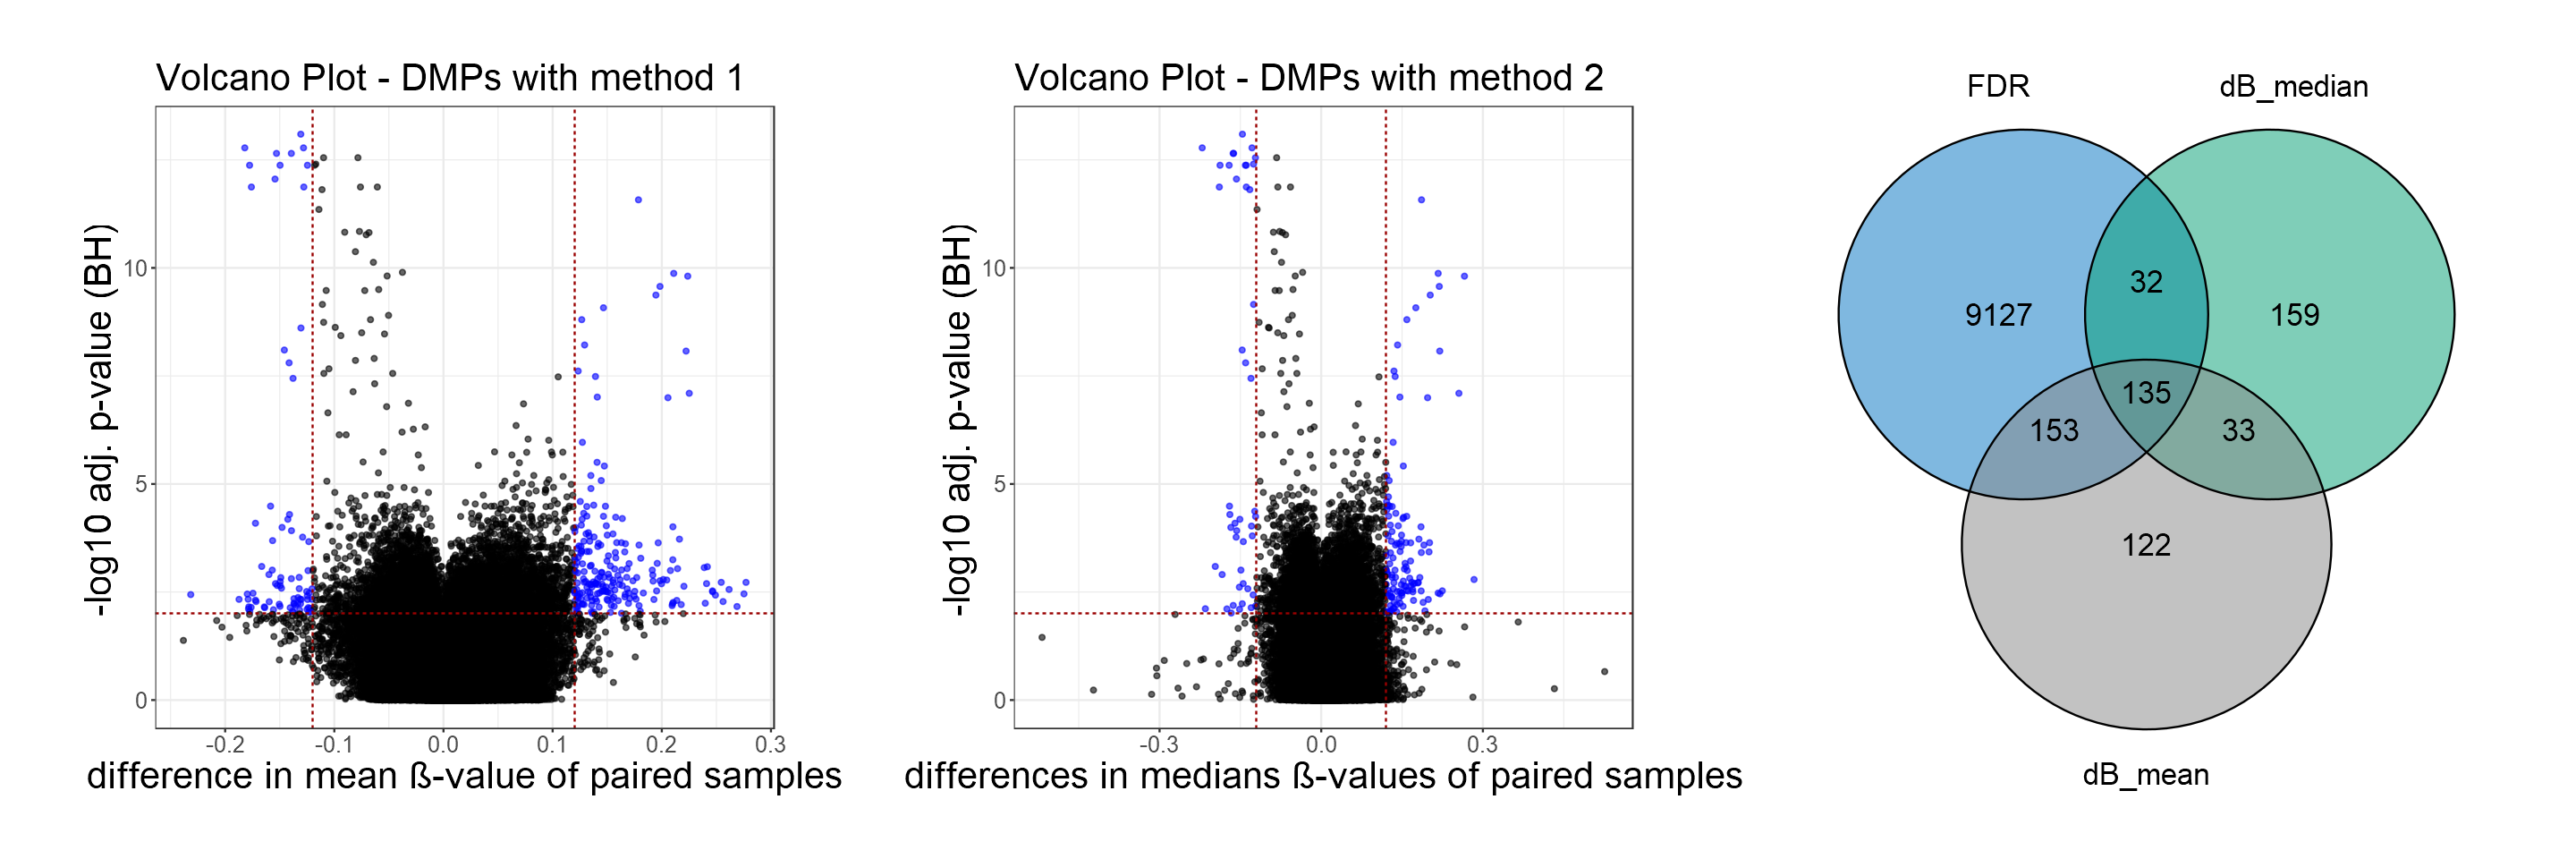

In [17]:
options(repr.plot.width=24, repr.plot.height=8)

plt_margin_txt = theme(legend.position = "none",
                       plot.margin = unit(c(1.5,2,1.5,2), "cm"),
                       plot.title = element_text(size=25,), 
                       axis.title.x = element_text(size=25), 
                       axis.text.x  = element_text(size=15),
                       axis.title.y = element_text(size=25),
                       axis.text.y  = element_text(size=15))
plt_margin = theme(plot.margin = unit(c(1.5,1.5,1.5,1.5), "cm"))

grid.arrange(
     DMA.CHARGE$volcano_mean + plt_margin_txt,
     DMA.CHARGE$volcano_median + plt_margin_txt,
     DMA.CHARGE$ven_dia + plt_margin,
     ncol=3#,
    # top = textGrob("Probe-wise Differential Methylation Analysis for CHARGE (FDR < 1%, abs(dB_t) >= 12%)",gp=gpar(fontsize=30))
     )

fig_buffer[[fig_id]] <- recordPlot()
fig_id = fig_id + 1

In [18]:
meth1_CpGs <- data.frame(DMA.CHARGE$dBmean_CpGs[rownames(DMA.CHARGE$dBmean_CpGs) %in% DMA.CHARGE$FDR_CpGs, ])
meth2_CpGs <- data.frame(DMA.CHARGE$dBmedian_CpGs[rownames(DMA.CHARGE$dBmedian_CpGs) %in% DMA.CHARGE$FDR_CpGs, ])
meth3_CpGs <- data.frame(DMA.CHARGE$dBmedian_CpGs[rownames(DMA.CHARGE$dBmedian_CpGs) %in% rownames(meth1_CpGs) & 
                                                  rownames(DMA.CHARGE$dBmedian_CpGs) %in% rownames(meth2_CpGs), ])

meth3_r <- sort(sample.int(nrow(GMset.CHARGE), nrow(meth3_CpGs), replace = F), decreasing = FALSE)

meth4_CpGs <- rownames(GMset.CHARGE[meth3_r, ])


GMsetDMPs.CHARGE <- list(
    m1  = combineArrays( GMset.GSE97362[rownames(GMset.GSE97362) %in% rownames(meth1_CpGs),],
                         GMset.GSE74432[rownames(GMset.GSE74432) %in% rownames(meth1_CpGs),]),
    m2  = combineArrays( GMset.GSE97362[rownames(GMset.GSE97362) %in% rownames(meth2_CpGs),],
                         GMset.GSE74432[rownames(GMset.GSE74432) %in% rownames(meth2_CpGs),]),
    m3  = combineArrays( GMset.GSE97362[rownames(GMset.GSE97362) %in% rownames(meth3_CpGs),],
                         GMset.GSE74432[rownames(GMset.GSE74432) %in% rownames(meth3_CpGs),]),
    m4  = combineArrays( GMset.GSE97362[rownames(GMset.GSE97362) %in% meth4_CpGs,],
                         GMset.GSE74432[rownames(GMset.GSE74432) %in% meth4_CpGs,])
)

# just to verify everythin is alright
table(rownames(GMsetDMPs.CHARGE$m1) %in% rownames(meth1_CpGs))
table(rownames(GMsetDMPs.CHARGE$m2) %in% rownames(meth2_CpGs))
table(rownames(GMsetDMPs.CHARGE$m3) %in% rownames(meth3_CpGs))
table(rownames(GMsetDMPs.CHARGE$m4) %in% meth4_CpGs)


TRUE 
 288 


TRUE 
 167 


TRUE 
 135 


TRUE 
 135 

In [19]:
save(GMsetDMPs.CHARGE, meta.CHARGE,file=file.path('FINAL_CHARGE.RData'))  
DMPs_to_csv(GMsetDMPs.CHARGE, meta.CHARGE, "CHARGE")

In [20]:
rm(list= c(  'GMsetDMPs.CHARGE', 'GMset.CHARGE'))
gc(reset = TRUE) 

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10354996,553.1,18272881,975.9,10354996,553.1
Vcells,841397794,6419.4,1294872800,9879.1,841397794,6419.4


### For Kabuki

In [21]:
DMA.KABUKI <- ProbeWise_DMA(GMset.KABUKI, meta.KABUKI, ctrl.KABUKI, case.KABUKI, dB_t=0.08)

0.08

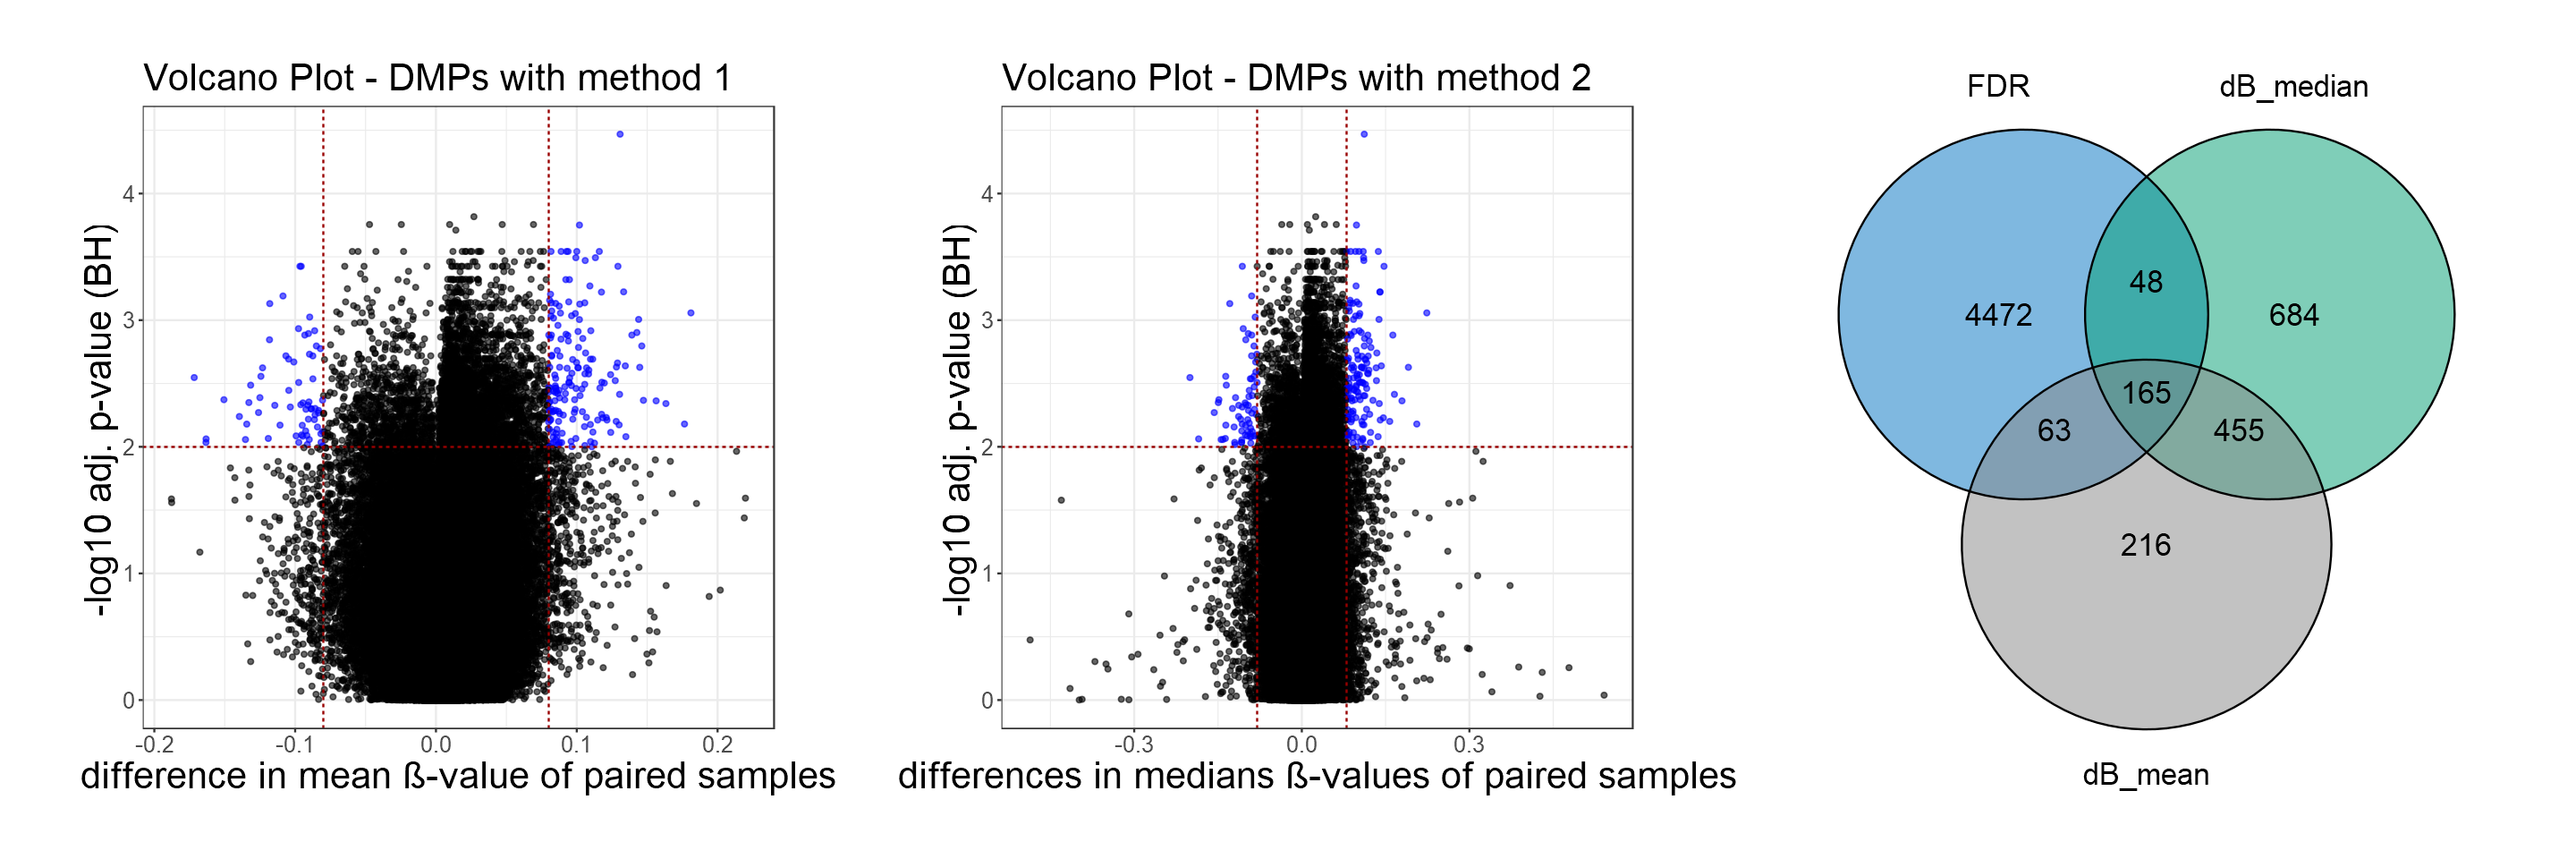

In [22]:
options(repr.plot.width=24, repr.plot.height=8)

plt_margin_txt = theme(legend.position = "none",
                       plot.margin = unit(c(1.5,2,1.5,2), "cm"),
                       plot.title = element_text(size=25,), 
                       axis.title.x = element_text(size=25), 
                       axis.text.x  = element_text(size=15),
                       axis.title.y = element_text(size=25),
                       axis.text.y  = element_text(size=15))
plt_margin = theme(plot.margin = unit(c(1.5,1.5,1.5,1.5), "cm"))

grid.arrange(
    DMA.KABUKI$volcano_mean + plt_margin_txt,
    DMA.KABUKI$volcano_median + plt_margin_txt,
    DMA.KABUKI$ven_dia + plt_margin,
    ncol=3#,
    #top = textGrob("Probe-wise Differential Methylation Analysis for KABUKI (FDR < 1%, abs(dB_t) >= 8%)",gp=gpar(fontsize=30))
    )

fig_buffer[[fig_id]] <- recordPlot()
fig_id = fig_id + 1

In [23]:
meth1_CpGs <- data.frame(DMA.KABUKI$dBmean_CpGs[rownames(DMA.KABUKI$dBmean_CpGs) %in% DMA.KABUKI$FDR_CpGs, ])
meth2_CpGs <- data.frame(DMA.KABUKI$dBmedian_CpGs[rownames(DMA.KABUKI$dBmedian_CpGs) %in% DMA.KABUKI$FDR_CpGs, ])
meth3_CpGs <- data.frame(DMA.KABUKI$dBmedian_CpGs[rownames(DMA.KABUKI$dBmedian_CpGs) %in% rownames(meth1_CpGs) & 
                                                  rownames(DMA.KABUKI$dBmedian_CpGs) %in% rownames(meth2_CpGs), ])
meth3_r <- sort(sample.int(nrow(GMset.KABUKI), nrow(meth3_CpGs), replace = F), decreasing = FALSE)

meth4_CpGs <- rownames(GMset.KABUKI[meth3_r, ])


GMsetDMPs.KABUKI <- list(
    m1  = combineArrays( GMset.GSE97362[rownames(GMset.GSE97362) %in% rownames(meth1_CpGs),],
                         GMset.GSE74432[rownames(GMset.GSE74432) %in% rownames(meth1_CpGs),]),
    m2  = combineArrays( GMset.GSE97362[rownames(GMset.GSE97362) %in% rownames(meth2_CpGs),],
                         GMset.GSE74432[rownames(GMset.GSE74432) %in% rownames(meth2_CpGs),]),
    m3  = combineArrays( GMset.GSE97362[rownames(GMset.GSE97362) %in% rownames(meth3_CpGs),],
                         GMset.GSE74432[rownames(GMset.GSE74432) %in% rownames(meth3_CpGs),]),
    m4  = combineArrays( GMset.GSE97362[rownames(GMset.GSE97362) %in% meth4_CpGs,],
                         GMset.GSE74432[rownames(GMset.GSE74432) %in% meth4_CpGs,])
)

# just to verify everythin is alright
table(rownames(GMsetDMPs.KABUKI$m1) %in% rownames(meth1_CpGs))
table(rownames(GMsetDMPs.KABUKI$m2) %in% rownames(meth2_CpGs))
table(rownames(GMsetDMPs.KABUKI$m3) %in% rownames(meth3_CpGs))
table(rownames(GMsetDMPs.KABUKI$m4) %in% meth4_CpGs)


TRUE 
 228 


TRUE 
 213 


TRUE 
 165 


TRUE 
 165 

In [24]:
save(GMsetDMPs.KABUKI, meta.KABUKI,file=file.path('FINAL_KABUKI.RData'))  
DMPs_to_csv(GMsetDMPs.KABUKI, meta.KABUKI, "KABUKI")

In [25]:
rm(list= c(  'GMsetDMPs.KABUKI', 'GMset.KABUKI'  ))
gc(reset = TRUE) 

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10396903,555.3,18272881,975.9,10396903,555.3
Vcells,934972138,7133.3,1553927360,11855.6,934972138,7133.3


### For Sotos

In [26]:
DMA.SOTOS <- ProbeWise_DMA(GMset.SOTOS, meta.SOTOS, ctrl.SOTOS, case.SOTOS, dB_t = 0.20)

0.2

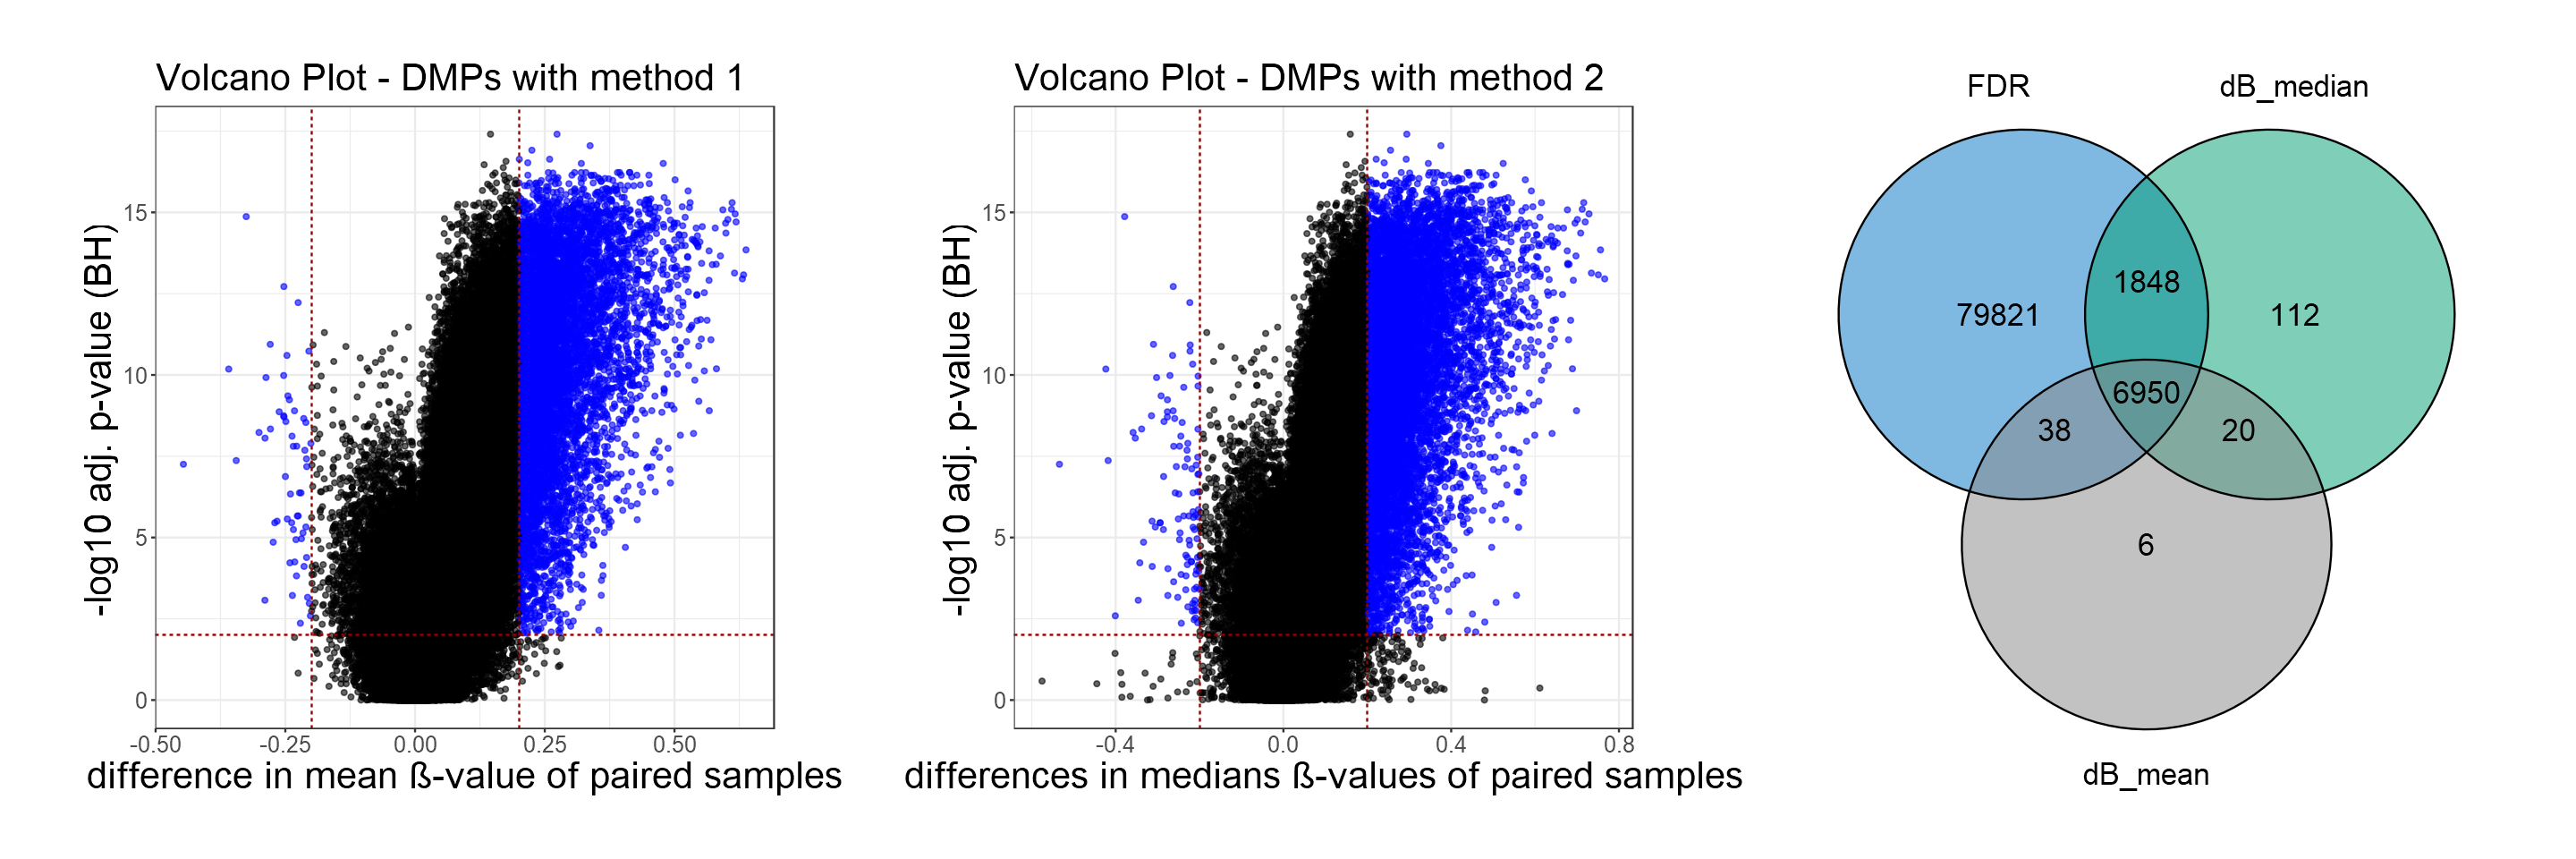

In [27]:
options(repr.plot.width=24, repr.plot.height=8)

plt_margin_txt = theme(legend.position = "none",
                       plot.margin = unit(c(1.5,2,1.5,2), "cm"),
                       plot.title = element_text(size=25,), 
                       axis.title.x = element_text(size=25), 
                       axis.text.x  = element_text(size=15),
                       axis.title.y = element_text(size=25),
                       axis.text.y  = element_text(size=15))
plt_margin = theme(plot.margin = unit(c(1.5,1.5,1.5,1.5), "cm"))

grid.arrange(
    DMA.SOTOS$volcano_mean + plt_margin_txt,
    DMA.SOTOS$volcano_median + plt_margin_txt,
    DMA.SOTOS$ven_dia + plt_margin,
    ncol=3#,
   # top = textGrob("Probe-wise Differential Methylation Analysis for SOTOS (FDR < 1%, abs(dB_t) >= 20%)",gp=gpar(fontsize=30))
    )

fig_buffer[[fig_id]] <- recordPlot()
fig_id = fig_id + 1


In [28]:
meth1_CpGs <- data.frame(DMA.SOTOS$dBmean_CpGs[rownames(DMA.SOTOS$dBmean_CpGs) %in% DMA.SOTOS$FDR_CpGs, ])
meth2_CpGs <- data.frame(DMA.SOTOS$dBmedian_CpGs[rownames(DMA.SOTOS$dBmedian_CpGs) %in% DMA.SOTOS$FDR_CpGs, ])
meth3_CpGs <- data.frame(DMA.SOTOS$dBmedian_CpGs[rownames(DMA.SOTOS$dBmedian_CpGs) %in% rownames(meth1_CpGs) & 
                                                  rownames(DMA.SOTOS$dBmedian_CpGs) %in% rownames(meth2_CpGs), ])

meth3_r <- sort(sample.int(nrow(GMset.SOTOS), nrow(meth3_CpGs), replace = F), decreasing = FALSE)

meth4_CpGs <- rownames(GMset.SOTOS[meth3_r, ])


GMsetDMPs.SOTOS <- list(
    m1  = combineArrays( GMset.GSE74432[rownames(GMset.GSE74432) %in% rownames(meth1_CpGs),],
                         GMset.GSE97362[rownames(GMset.GSE97362) %in% rownames(meth1_CpGs),]),
    m2  = combineArrays( GMset.GSE74432[rownames(GMset.GSE74432) %in% rownames(meth2_CpGs),],
                         GMset.GSE97362[rownames(GMset.GSE97362) %in% rownames(meth2_CpGs),]),
    m3  = combineArrays( GMset.GSE74432[rownames(GMset.GSE74432) %in% rownames(meth3_CpGs),],
                         GMset.GSE97362[rownames(GMset.GSE97362) %in% rownames(meth3_CpGs),]),
    m4  = combineArrays( GMset.GSE74432[rownames(GMset.GSE74432) %in% meth4_CpGs,],
                         GMset.GSE97362[rownames(GMset.GSE97362) %in% meth4_CpGs,])
)

# just to verify everythin is alright
table(rownames(GMsetDMPs.SOTOS$m1) %in% rownames(meth1_CpGs))
table(rownames(GMsetDMPs.SOTOS$m2) %in% rownames(meth2_CpGs))
table(rownames(GMsetDMPs.SOTOS$m3) %in% rownames(meth3_CpGs))
table(rownames(GMsetDMPs.SOTOS$m3_r) %in% meth4_CpGs)


TRUE 
6986 


TRUE 
8797 


TRUE 
6949 

< table of extent 0 >

In [29]:
save(GMsetDMPs.SOTOS, meta.SOTOS,file=file.path('FINAL_SOTOS.RData'))  
DMPs_to_csv(GMsetDMPs.SOTOS, meta.SOTOS, "SOTOS")

In [30]:
rm(list= c(  'GMsetDMPs.SOTOS', 'GMset.SOTOS'  ))
gc(reset = TRUE) 

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10437968,557.5,18272881,975.9,10437968,557.5
Vcells,1056463297,8060.2,1553927360,11855.6,1056463297,8060.2


### For CTRL vs CTRL from diff batch

In [31]:
DMA.CTRL <- ProbeWise_DMA(GMset.CTRL, meta.CTRL, ctrl_GSE97362.CTRL, case_GSE74432.CTRL, dB_t=0.08)

0.08

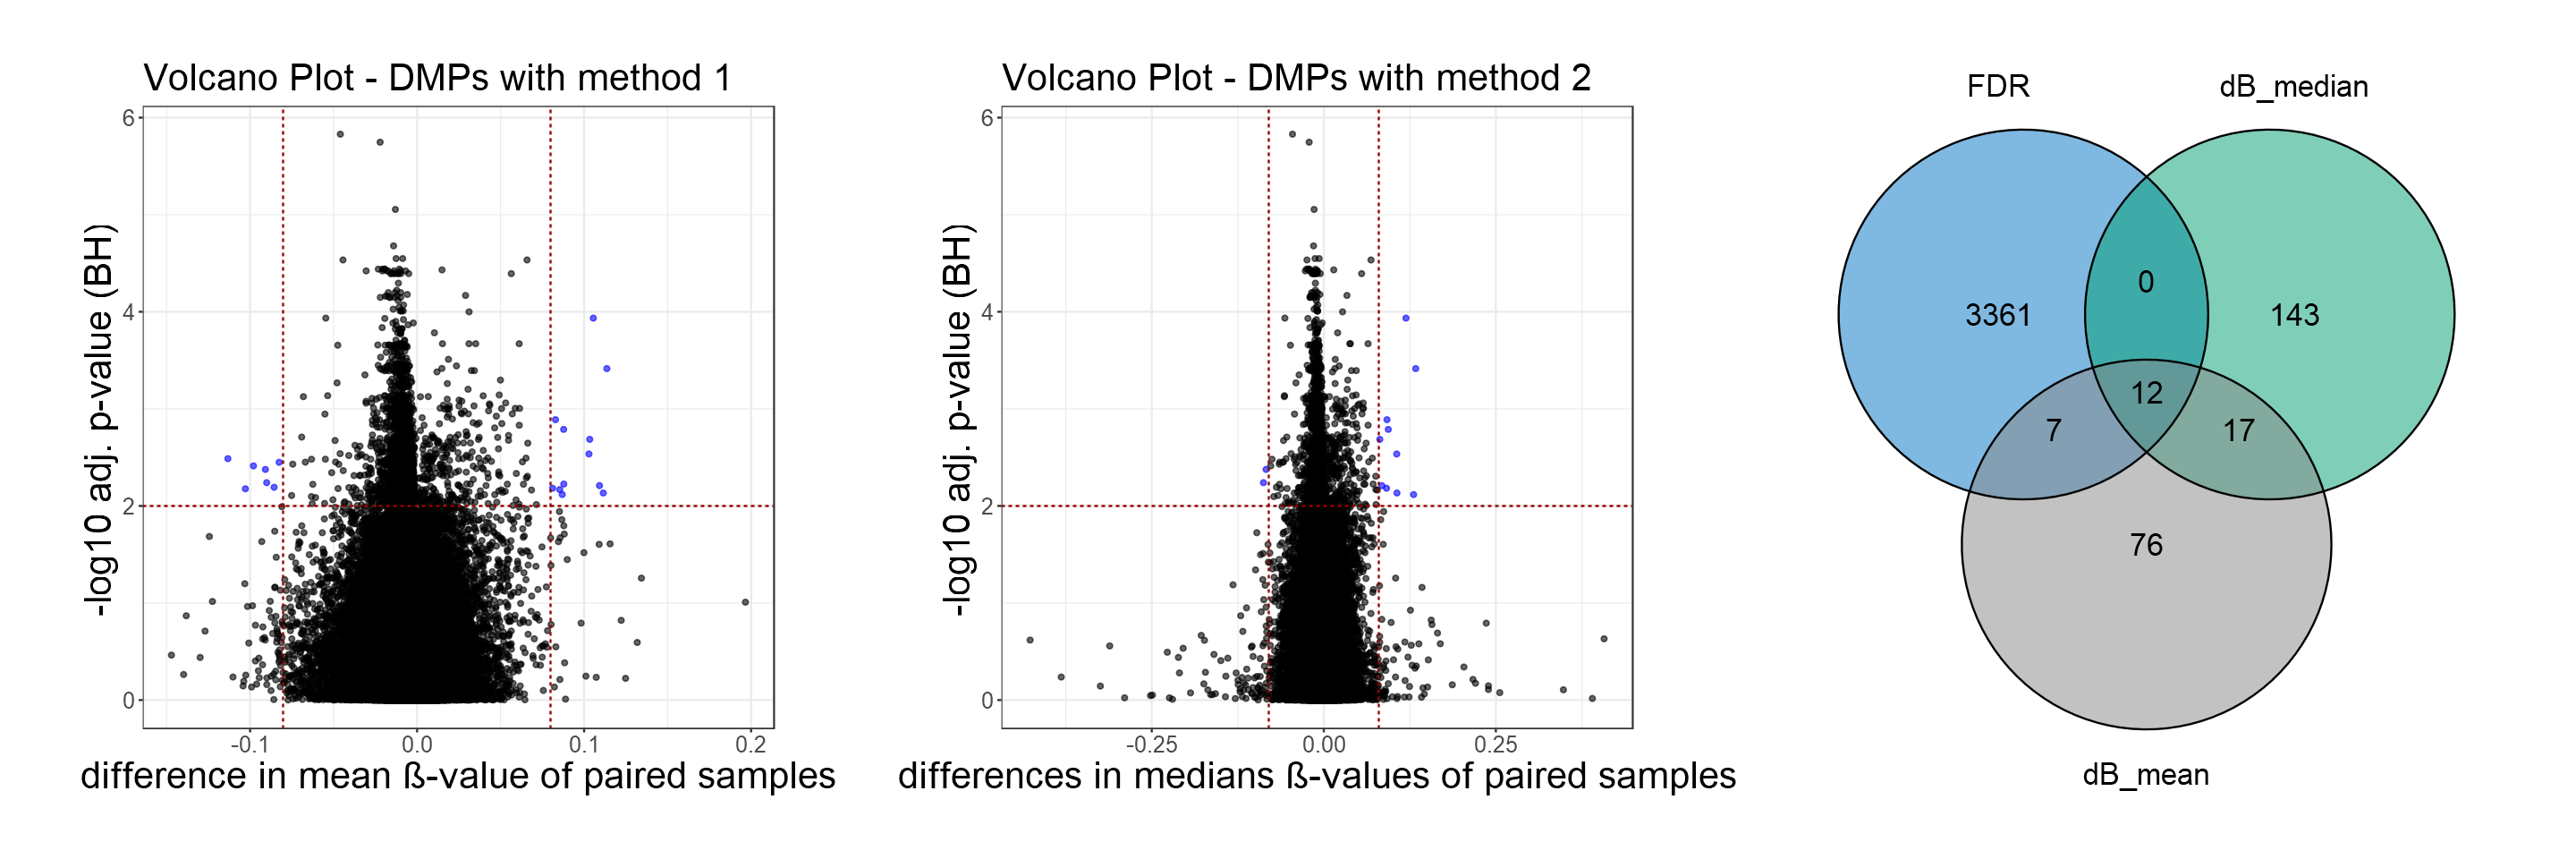

In [32]:
options(repr.plot.width=24, repr.plot.height=8)

plt_margin_txt = theme(legend.position = "none",
                       plot.margin = unit(c(1.5,2,1.5,2), "cm"),
                       plot.title = element_text(size=25,), 
                       axis.title.x = element_text(size=25), 
                       axis.text.x  = element_text(size=15),
                       axis.title.y = element_text(size=25),
                       axis.text.y  = element_text(size=15))
plt_margin = theme(plot.margin = unit(c(1.5,1.5,1.5,1.5), "cm"))

grid.arrange(
    DMA.CTRL$volcano_mean + plt_margin_txt,
    DMA.CTRL$volcano_median + plt_margin_txt,
    DMA.CTRL$ven_dia + plt_margin,
    ncol=3#,
    #top = textGrob("Probe-wise Differential Methylation Analysis for CTRL_GSE97362 vs CTRL_GSE74432 (FDR < 1%, abs(dB_t) >= 8%)",gp=gpar(fontsize=30))
    )

fig_buffer[[fig_id]] <- recordPlot()
fig_id = fig_id + 1

In [33]:
meth1_CpGs <- data.frame(DMA.CTRL$dBmean_CpGs[rownames(DMA.CTRL$dBmean_CpGs) %in% DMA.CTRL$FDR_CpGs, ])
meth2_CpGs <- data.frame(DMA.CTRL$dBmedian_CpGs[rownames(DMA.CTRL$dBmedian_CpGs) %in% DMA.CTRL$FDR_CpGs, ])
meth3_CpGs <- data.frame(DMA.CTRL$dBmedian_CpGs[rownames(DMA.CTRL$dBmedian_CpGs) %in% rownames(meth1_CpGs) & 
                                                rownames(DMA.CTRL$dBmedian_CpGs) %in% rownames(meth2_CpGs), ])

meth4_CpGs <- sort(sample.int(nrow(GMset.CTRL), nrow(meth3_CpGs), replace = F), decreasing = FALSE)

GMsetDMPs.CTRL <- list(
    m1 = GMset.CTRL[rownames(GMset.CTRL) %in% rownames(meth1_CpGs),],
    m2 = GMset.CTRL[rownames(GMset.CTRL) %in% rownames(meth2_CpGs),],
    m3 = GMset.CTRL[rownames(GMset.CTRL) %in% rownames(meth3_CpGs),],
    m4 = GMset.CTRL[meth4_CpGs,]
)

# just to verify everythin is alright
table(rownames(GMsetDMPs.CTRL$m1) == rownames(meth1_CpGs))
table(rownames(GMsetDMPs.CTRL$m2) == rownames(meth2_CpGs))
table(rownames(GMsetDMPs.CTRL$m3) == rownames(meth3_CpGs))
nrow(GMsetDMPs.CTRL$m4)


TRUE 
  19 


TRUE 
  12 


TRUE 
  12 

[1] 12

In [34]:
#save(GMsetDMPs.CTRL, meta.CTRL,file=file.path('FINAL_CTRL.RData'))  
#DMPs_to_csv(GMsetDMPs.CTRL, meta.CTRL, "CTRL")

In [35]:
rm(list= c(  'GMsetDMPs.CTRL'  ))
gc(reset = TRUE) 

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,10479036,559.7,18272881,975.9,10479036,559.7
Vcells,1177441327,8983.2,1864792832,14227.3,1177441327,8983.2


In [36]:
pdf(file= file.path('DMA_figures.pdf',sep='') , width=15, height=5, useDingbats=FALSE)
for (fig in fig_buffer) {
    replayPlot(fig)
}
graphics.off()

In [37]:
meta.GSE97362[meta.GSE97362$disease_id == 'CTRL',]$disease_id <- 'CTRL1'
meta.GSE74432[meta.GSE74432$disease_id == 'CTRL',]$disease_id <- 'CTRL2'

In [38]:
table(meta.GSE97362$disease_id)
table(meta.GSE74432$disease_id)


 CHD7 CTRL1 KDM6A KMT2D 
   72   124     1    37 


CTRL2  NSD1 
   53    54 

In [39]:
y <- rbind(meta.GSE97362[,c('geo_accession','disease_id')], meta.GSE74432[,c('geo_accession','disease_id')])

write.csv(y, 'ALL-y.csv')

---

In [41]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 22000)

Matrix products: default

locale:
[1] LC_COLLATE=English_Belgium.1252  LC_CTYPE=English_Belgium.1252   
[3] LC_MONETARY=English_Belgium.1252 LC_NUMERIC=C                    
[5] LC_TIME=English_Belgium.1252    

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ggvenn_0.1.9                dplyr_1.0.8                
 [3] ggfortify_0.4.14            gridExtra_2.3              
 [5] Rtsne_0.15                  devtools_2.4.3             
 [7] usethis_2.1.6               RColorBrewer_1.1-3         
 [9] ggrepel_0.9.1               ggplot2_3.3.6              
[11] minfi_1.40.0                bumphunter_1.36.0          
[13] locfit_1.5-9.4              iterators_1.0.14           
[15] foreach_1.5.2               Biostrings_2.62.0          
[17] XVector_0.34.0     